In [1]:
import pandas as pd
import numpy as np

from tqdm import tqdm
import time
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

## [A.] Loading and Preprocessing Data

### [A. 1.] Load Follower data 
    The collected data contains follower of each Source userid. 

In [2]:
follower_network_df = pd.read_csv('./R1DATA/PROCESSED/followers_edge_list.csv', dtype={'Source':str, 'Target':str})
follower_network_df

,Source,Target
0,1004065528871247872,832703749374177282
1,1004065528871247872,217474455
2,1004065528871247872,149283816
3,1004065528871247872,1475910062484819968
4,1004065528871247872,262675787
...,...,...
91086,739280043243802626,600334022
91087,739280043243802626,717466226453118976
91088,739280043243802626,4599712092
91089,1205444605,846095228


In [3]:
follower_network_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91091 entries, 0 to 91090
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Source  91091 non-null  object
 1   Target  91091 non-null  object
dtypes: object(2)
memory usage: 1.4+ MB


In [4]:
all_follower_data_users = set( follower_network_df['Source'].unique() ).union(set( follower_network_df['Target'].unique() ))
len(all_follower_data_users)

4030

### [A. 2.] Load twitter messages data
    Tweets (including retweets, quoted tweets, replies) of these users in Twitter for the considered duration of time. These data are requried for constructing retweet based and transfer entropy based networks.
    Each record is a Tweet
    Columns : 
     - author_id : author
     - in_reply_to_user_id : the author id of the parent Tweet if this Tweet is a reply/retweet/quote
     - created_at : datetime of the Tweet in UTC time
     - mentions_count : number of authors mentioned in the text of the Tweet
     - mentions : author id list of authors mentioned in the text of the Tweet

In [5]:
%%time

all_osn_msgs_df = pd.read_csv('./R1DATA/PROCESSED/data_minimal_str.csv', 
                              dtype={'author_id':str,'in_reply_to_user_id':str,'mentions_count':int}, 
                              parse_dates=['created_at'], date_parser= lambda x: datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.000Z"), 
                              converters={'mentions':eval})

CPU times: user 4min 3s, sys: 3.36 s, total: 4min 7s
Wall time: 4min 7s


In [6]:
all_osn_msgs_df

,author_id,in_reply_to_user_id,created_at,mentions_count,mentions
0,1432919429831020552,NaN,2022-01-21 23:36:56,3,"[233058170, 878284831, 828035864278151168]"
1,1432919429831020552,NaN,2022-01-21 23:35:43,2,"[1382839661811351553, 878284831]"
2,1432919429831020552,NaN,2022-01-21 23:35:39,2,"[213134269, 878284831]"
3,1432919429831020552,NaN,2022-01-21 23:35:33,2,"[1293160564483665920, 878284831]"
4,1432919429831020552,NaN,2022-01-21 23:35:27,2,"[1162118566226878469, 878284831]"
...,...,...,...,...,...
14060530,896496644656685056,NaN,2022-01-13 20:49:18,1,[2292488509]
14060531,1939118838,NaN,2022-01-13 20:49:14,1,[1005846500583321601]
14060532,896496644656685056,NaN,2022-01-13 20:49:09,1,[1470378545146912770]
14060533,896496644656685056,NaN,2022-01-13 20:49:03,1,[2400284491]


In [7]:
all_osn_msgs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14060535 entries, 0 to 14060534
Data columns (total 5 columns):
 #   Column               Dtype         
---  ------               -----         
 0   author_id            object        
 1   in_reply_to_user_id  object        
 2   created_at           datetime64[ns]
 3   mentions_count       int64         
 4   mentions             object        
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 536.4+ MB


In [8]:
print(f"Data available for period : {all_osn_msgs_df['created_at'].min()} to {all_osn_msgs_df['created_at'].max()}")

Data available for period : 2021-12-01 05:00:00 to 2022-04-01 04:59:58


### [A. 3.] Filter data for intersecion of users from all data sources

#### [A. 3. 1.] Construct the focused set of users as interseciton of user sets from all data

In [9]:
all_mentioned_users = set()
all_osn_msgs_df['mentions'].apply(lambda x: [all_mentioned_users.add(e) for e in x])
print(f"Mentioned users count : {len(all_mentioned_users)}")

all_tweet_data_users = set( all_osn_msgs_df['author_id'].unique() ).union(set( all_osn_msgs_df['in_reply_to_user_id'].unique() ))
all_tweet_data_users = all_tweet_data_users.union(all_mentioned_users)
print(f"All users in tweet data : {len(all_tweet_data_users)}")

all_users = all_follower_data_users.intersection(all_tweet_data_users)
print(f"Considered count of users : {len(all_users)}")
del all_mentioned_users
del all_tweet_data_users

Mentioned users count : 1233934
All users in tweet data : 1264768
Considered count of users : 3975


#### [A. 3. 2.] Filter the focused users from Tweet dataset

In [10]:
all_osn_msgs_df['mentions'] = all_osn_msgs_df['mentions'].apply(lambda x: list(all_users.intersection(x)))

In [11]:
all_osn_msgs_df['mentions_count'] = all_osn_msgs_df['mentions'].apply(lambda x: len(x))

In [12]:
all_osn_msgs_df = all_osn_msgs_df[(all_osn_msgs_df['in_reply_to_user_id'].isin(all_users) | all_osn_msgs_df['in_reply_to_user_id'].isnull()) & all_osn_msgs_df['author_id'].isin(all_users)]

In [13]:
all_osn_msgs_df = all_osn_msgs_df.sort_values('created_at').reset_index(drop=True)
all_osn_msgs_df

,author_id,in_reply_to_user_id,created_at,mentions_count,mentions
0,13719342,NaN,2021-12-01 05:00:00,0,[]
1,14885540,NaN,2021-12-01 05:00:00,0,[]
2,3301782494,NaN,2021-12-01 05:00:00,0,[]
3,21265939,NaN,2021-12-01 05:00:01,0,[]
4,501397421,NaN,2021-12-01 05:00:01,0,[]
...,...,...,...,...,...
12543869,1343916687326851072,NaN,2022-04-01 04:59:56,0,[]
12543870,1158841136439427072,NaN,2022-04-01 04:59:57,0,[]
12543871,126075164,NaN,2022-04-01 04:59:57,0,[]
12543872,3262551006,NaN,2022-04-01 04:59:57,0,[]


#### [A. 3. 3.] Filter the focused users from Follower dataset

In [14]:
follower_network_df = follower_network_df[follower_network_df['Source'].isin(all_users) & follower_network_df['Target'].isin(all_users)]
follower_network_df.reset_index(drop=True, inplace=True)
follower_network_df

,Source,Target
0,1004065528871247872,832703749374177282
1,1004065528871247872,217474455
2,1004065528871247872,149283816
3,1004065528871247872,1475910062484819968
4,1004065528871247872,262675787
...,...,...
90647,739280043243802626,600334022
90648,739280043243802626,717466226453118976
90649,739280043243802626,4599712092
90650,1205444605,846095228


### [A. 4.] Calculate time in EST

In [15]:
all_osn_msgs_df['created_at_est'] = all_osn_msgs_df['created_at'] - timedelta(hours=5)

In [16]:
all_osn_msgs_df.drop(columns=['created_at'], inplace=True)

In [17]:
all_osn_msgs_df

,author_id,in_reply_to_user_id,mentions_count,mentions,created_at_est
0,13719342,NaN,0,[],2021-12-01 00:00:00
1,14885540,NaN,0,[],2021-12-01 00:00:00
2,3301782494,NaN,0,[],2021-12-01 00:00:00
3,21265939,NaN,0,[],2021-12-01 00:00:01
4,501397421,NaN,0,[],2021-12-01 00:00:01
...,...,...,...,...,...
12543869,1343916687326851072,NaN,0,[],2022-03-31 23:59:56
12543870,1158841136439427072,NaN,0,[],2022-03-31 23:59:57
12543871,126075164,NaN,0,[],2022-03-31 23:59:57
12543872,3262551006,NaN,0,[],2022-03-31 23:59:57


## Data Inspection and Visulization

In [18]:
msg_count_vs_time = all_osn_msgs_df.set_index('created_at_est').resample('D').size()
msg_count_vs_time

created_at_est
2021-12-01    106171
2021-12-02     98075
2021-12-03     94360
2021-12-04     84089
2021-12-05     87497
               ...  
2022-03-27     90196
2022-03-28    101717
2022-03-29    107017
2022-03-30    107511
2022-03-31    102842
Freq: D, Length: 121, dtype: int64

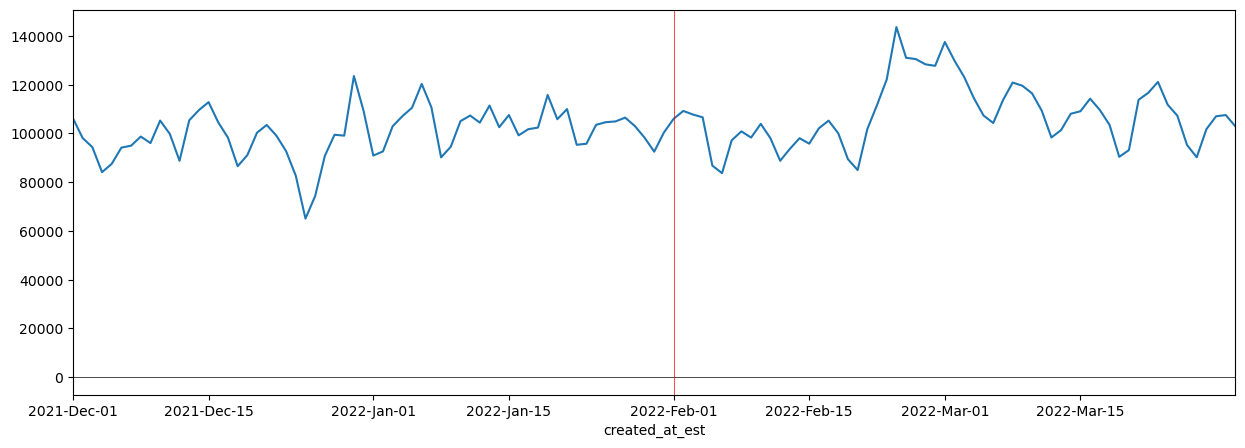

In [20]:
fig, ax = plt.subplots(figsize=(15,5))
msg_count_vs_time.plot()
plt.axhline(0, color='black', linewidth=.5)
plt.axvline(datetime.strptime("2022-02-01", "%Y-%m-%d"), color='red', linewidth=.5)
date_form = mdates.DateFormatter("%Y-%b-%d")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.DayLocator(bymonthday=[1,15], interval=1))
ax.xaxis.set_minor_locator(mdates.YearLocator(month=5))
#ax.xaxis.set_tick_params(rotation=30, labelsize=10)
plt.show()

### Data separation for Training and Testing

In [21]:
train_start_time = datetime.strptime("2021-12-01", "%Y-%m-%d")
train_end_time = datetime.strptime("2022-02-01", "%Y-%m-%d")
test_start_time = train_end_time
test_end_time = datetime.strptime("2022-02-15", "%Y-%m-%d")

print(f"Training data : {train_start_time} <= train < {train_end_time}")
print(f"Testing data : {test_start_time} <= test < {test_end_time}")

Training data : 2021-12-01 00:00:00 <= train < 2022-02-01 00:00:00
Testing data : 2022-02-01 00:00:00 <= test < 2022-02-15 00:00:00


In [22]:
train_msgs_df = all_osn_msgs_df[(train_start_time <= all_osn_msgs_df['created_at_est']) & (all_osn_msgs_df['created_at_est'] < train_end_time)]
train_msgs_df

,author_id,in_reply_to_user_id,mentions_count,mentions,created_at_est
0,13719342,NaN,0,[],2021-12-01 00:00:00
1,14885540,NaN,0,[],2021-12-01 00:00:00
2,3301782494,NaN,0,[],2021-12-01 00:00:00
3,21265939,NaN,0,[],2021-12-01 00:00:01
4,501397421,NaN,0,[],2021-12-01 00:00:01
...,...,...,...,...,...
6192422,1320037645,NaN,0,[],2022-01-31 23:59:55
6192423,1410351193587585026,NaN,0,[],2022-01-31 23:59:55
6192424,1218640225230114816,NaN,0,[],2022-01-31 23:59:55
6192425,126075164,NaN,0,[],2022-01-31 23:59:57


In [23]:
test_msgs_df = all_osn_msgs_df[(test_start_time <= all_osn_msgs_df['created_at_est']) & (all_osn_msgs_df['created_at_est'] < test_end_time)]
test_msgs_df

,author_id,in_reply_to_user_id,mentions_count,mentions,created_at_est
6192427,560821229,NaN,0,[],2022-02-01 00:00:00
6192428,15488142,174773888,1,[174773888],2022-02-01 00:00:00
6192429,1410351193587585026,NaN,0,[],2022-02-01 00:00:01
6192430,1343916687326851072,NaN,0,[],2022-02-01 00:00:01
6192431,13719342,NaN,0,[],2022-02-01 00:00:01
...,...,...,...,...,...
7570903,992890858339905537,NaN,0,[],2022-02-14 23:59:56
7570904,126075164,NaN,0,[],2022-02-14 23:59:57
7570905,79524514,NaN,0,[],2022-02-14 23:59:58
7570906,17434625,NaN,0,[],2022-02-14 23:59:59


## Common Functions

In [24]:
def print_network_info(in_edge_list_df, in_source_col, in_target_col):
    src_nodes = set(in_edge_list_df[in_source_col].unique())
    print(f"All Source nodes count: {len(src_nodes)}")

    tgt_nodes = set(in_edge_list_df[in_target_col].unique())
    print(f"All Target nodes count: {len(tgt_nodes)}")

    all_nodes = src_nodes.union(tgt_nodes)
    print(f"All nodes count: {len(all_nodes)}")

    src_only = src_nodes.difference(tgt_nodes)
    print(f"Zero in-degree nodes count: {len(src_only)}")

    tgt_only = tgt_nodes.difference(src_nodes)
    print(f"Zero out-degree nodes count: {len(tgt_only)}")
    
    return all_nodes

## Follower Network

In [60]:
follower_network_df

,Source,Target
0,1004065528871247872,832703749374177282
1,1004065528871247872,217474455
2,1004065528871247872,149283816
3,1004065528871247872,1475910062484819968
4,1004065528871247872,262675787
...,...,...
90647,739280043243802626,600334022
90648,739280043243802626,717466226453118976
90649,739280043243802626,4599712092
90650,1205444605,846095228


In [25]:
_ = print_network_info(follower_network_df, 'Source', 'Target')

All Source nodes count: 3345
All Target nodes count: 3893
All nodes count: 3975
Zero in-degree nodes count: 82
Zero out-degree nodes count: 630


## Retweet Network

In [62]:
retweet_network_df = train_msgs_df[['in_reply_to_user_id','author_id']].value_counts().rename('NumRetweets').reset_index()
retweet_network_df

,in_reply_to_user_id,author_id,NumRetweets
0,1397498835463774208,1397498835463774208,2544
1,4311670299,4311670299,1536
2,15692273,15692273,1412
3,620136960,620136960,1199
4,1218640225230114816,1218640225230114816,988
...,...,...,...
7479,146569971,419256305,1
7480,30570552,183636302,1
7481,146569971,38978291,1
7482,305747843,305747843,1


In [63]:
_ = print_network_info(retweet_network_df, 'in_reply_to_user_id', 'author_id')

All Source nodes count: 2582
All Target nodes count: 2562
All nodes count: 2749
Zero in-degree nodes count: 187
Zero out-degree nodes count: 167


## Mention Network

"A mention is a Tweet that contains another person’s username anywhere in the body of the Tweet. 
We collect these messages, as well as all your replies, in your Notifications tab.
If you include multiple usernames in your Tweet, all of those people will see your Tweet in their Notifications tab." - Twitter Help URL : https://help.twitter.com/en/using-twitter/mentions-and-replies 

In [51]:
mentions_network_df = []
train_msgs_df[train_msgs_df['mentions_count'] > 0][['author_id','mentions']].apply(lambda row: [(mentions_network_df.append([m, row['author_id']]) if m != row['author_id'] else None) for m in row['mentions']], axis=1)
mentions_network_df = pd.DataFrame(mentions_network_df, columns=['mentioned','author_id'])
mentions_network_df = mentions_network_df.value_counts().rename('NumMentions').reset_index()
mentions_network_df

,mentioned,author_id,NumMentions
0,17919393,134971995,1782
1,29097819,1310982818206547968,1327
2,15220806,591166408,1133
3,9275052,75725564,1021
4,29097819,1159924250624569344,866
...,...,...,...
32354,2187906247,2179399914,1
32355,2187906247,217474455,1
32356,2187906247,21612122,1
32357,2187906247,21265939,1


In [52]:
_ = print_network_info(mentions_network_df, 'mentioned', 'author_id')

All Source nodes count: 2498
All Target nodes count: 3338
All nodes count: 3587
Zero in-degree nodes count: 249
Zero out-degree nodes count: 1089


## Retweet/Mention Network
This network consists of relationships that show influence based on either retweets or mentions

In [107]:
retweet_mention_network_df = pd.concat([retweet_network_df.rename(columns={'in_reply_to_user_id':'mentioned','NumRetweets':'NumMentions'}), mentions_network_df], ignore_index=True)
retweet_mention_network_df.rename(columns={'mentioned':'Parent','NumMentions':'NumInteractions'}, inplace=True)
retweet_mention_network_df = retweet_mention_network_df.groupby(['Parent','author_id']).sum().sort_values('NumInteractions', ascending=False).reset_index()
retweet_mention_network_df

,Parent,author_id,NumInteractions
0,1397498835463774208,1397498835463774208,2544
1,17919393,134971995,1782
2,4311670299,4311670299,1536
3,15692273,15692273,1412
4,29097819,1310982818206547968,1327
...,...,...,...
34768,14505838,427515851,1
34769,2788847458,1031988280215130118,1
34770,2787151046,2241611058,1
34771,14505838,4481687056,1
